In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
#from spacy.lang.en.stop_words import STOP_WORDS
import nltk

In [17]:
complaints = pd.read_csv("data/complaints-2019-05-16_13_17.csv")
complaints = complaints.dropna(subset=["Consumer disputed?"])

/anaconda3/envs/insight/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
complaints.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
21029,08/25/15,Bank account or service,Checking account,Problems caused by my funds being low,None,I have a complaint regarding the overdraft fee...,Company chooses not to provide a public response,"FLAGSTAR BANK, FSB",MI,480XX,None,Consent provided,Web,08/25/15,Closed with explanation,Yes,No,1535719
21030,08/25/15,Credit reporting,None,Incorrect information on credit report,Account terms,XXXX Collections Account # XXXX is reporting o...,None,"EQUIFAX, INC.",LA,708XX,None,Consent provided,Web,08/25/15,Closed with explanation,Yes,No,1535563
21031,08/25/15,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",None,I just filled this out but web site timed out ...,None,"Seterus, Inc.",CA,926XX,None,Consent provided,Web,08/25/15,Closed with explanation,Yes,No,1535476
21032,08/25/15,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Right to dispute notice not received,This file has been relisted on my credit repor...,Company believes it acted appropriately as aut...,ERC,FL,None,None,Consent provided,Web,09/02/15,Closed with non-monetary relief,Yes,No,1534483
21033,08/25/15,Mortgage,Home equity loan or line of credit,"Loan modification,collection,foreclosure",None,We took out a HELOC XXXX years ago. We thought...,Company believes it acted appropriately as aut...,Ditech Financial LLC,FL,None,Older American,Consent provided,Web,09/02/15,Closed with explanation,Yes,No,1535621


In [8]:
complaints_narrative = complaints.loc[:, ["Complaint ID","Consumer complaint narrative", "Consumer disputed?"]]
print("There are {} complaints with narrative with label".format(len(complaints_narrative)))

There are 164076 complaints with narrative with label


### Revisit Vader whether there is difference between dispute group and not dispute group

In [10]:
dispute_complaints = complaints[complaints["Consumer disputed?"] == "Yes"]
not_dispute_complaints = complaints[complaints["Consumer disputed?"] == "No"]

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def vader_score(narratives):
    analyser = SentimentIntensityAnalyzer()

    sentiment_score_list = []
    for narrative in narratives:
        score = analyser.polarity_scores(narrative)
        sentiment_score_list.append(score["compound"])
    
    return sentiment_score_list



In [12]:
scores_dispute = vader_score(dispute_complaints["Consumer complaint narrative"])
scores_not_dispute = vader_score(not_dispute_complaints["Consumer complaint narrative"])

Text(0.5, 1.0, 'Distribution of sentiment score in dispute_complaints and not dispute complaints')

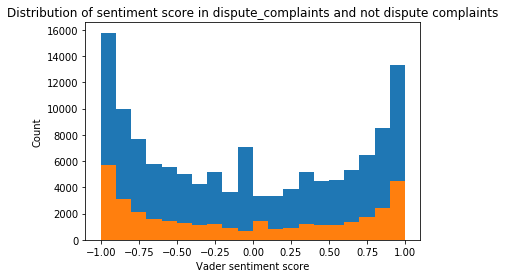

In [17]:

plt.hist(scores_not_dispute, bins = 20)
plt.hist(scores_dispute, bins = 20)
plt.xlabel("Vader sentiment score")
plt.ylabel("Count")
plt.title("Distribution of sentiment score in dispute_complaints and not dispute complaints")

In [38]:
x = 'a'
x == '?'

False

In [35]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def LDA(text):
    vect = CountVectorizer(max_features=10000, ngram_range=(1,3), min_df=5, stop_words="english")
    #vect = CountVectorizer(ngram_range=(1,3), min_df=5, stop_words="english")
    X = vect.fit_transform(text)
    #X = vect.fit_transform(text_train)

    lda = LatentDirichletAllocation(n_topics=5, learning_method="batch",
                                    max_iter=25, random_state=0)
    # We build the model and transform the data in one step
    # Computing transform makes some time,
    document_topics = lda.fit_transform(X)

    print(lda.components_.shape)

    sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
    feature_names = np.array(vect.get_feature_names())
    
    print(feature_names[:100])
    return lda, vect

In [36]:

sub_complaints = complaints["cleaned_narrative"]

lda, vect = LDA(sub_complaints[:1000])

/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


(5, 2894)
['ability' 'able' 'able forward' 'able forward credit' 'able make'
 'able pay' 'able provide' 'able verify' 'able verify identity'
 'absolutely' 'abusive' 'accept' 'acceptable' 'acceptance' 'accepted'
 'accepting' 'access' 'access account' 'accessed' 'accident' 'accordance'
 'according' 'account' 'account account' 'account balance' 'account bank'
 'account called' 'account closed' 'account company' 'account credit'
 'account credit report' 'account current' 'account date' 'account day'
 'account days' 'account did' 'account does' 'account immediately'
 'account information' 'account like' 'account listed' 'account month'
 'account number' 'account open' 'account opened' 'account paid'
 'account pay' 'account payments' 'account received' 'account removed'
 'account reported' 'account said' 'account sent' 'account status'
 'account time' 'account told' 'account transferred' 'account went'
 'account xx' 'account xx xx' 'account years' 'accounting' 'accounts'
 'accounts good' 'ac

### Preprocessing including tokenization, lemmarization

In [70]:
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
#from spacy.lang.en.stop_words import STOP_WORDS
import nltk


def merge_stop_word():
    """Merge stop words from three library"""
    all_stopwords = set(stopwords.words('english'))
    #all_stopwords.add(STOP_WORDS)
    for word in ENGLISH_STOP_WORDS:
        all_stopwords.add(word)

    words_with_emotion = ['never', 'aren', 'neither', 'cannot', 'nobody', 'why', 'not', "don't", 'nor', 'whatever', "aren't", 'should', 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    for x in words_with_emotion:
        all_stopwords.remove(x)

    return list(all_stopwords)

def convert_pos_tag(tag):
    """
    Input: Parts-of-speech tag in Penn TreeBank format.
    Function: convert the first letter of Penn pos-tag to a form NLTK can use
    Output: NLTK-compatible pos-tag.
    """
    pos = {'N' : 'n', 'V' : 'v', 'J' : 'a', 'S' : 's', 'R' : 'r'}
    if tag in pos.keys(): return pos[tag]
    else: return 'n' # everything else = noun.


def pre_process_narrative(narrative):
    """Work with one complaint narrative"""
    # subtitute digits in the narrative into digits. There are not useful for text classification
    narrative = re.sub(r"\d+", "DIGITS", narrative)

    # Prepare stop-words list
    all_stopwords = merge_stop_word()

    # Tokenize the narrative
    tokens = [word.lower() for word in nltk.word_tokenize(narrative) if word.isalpha()]
    tokens_pos = nltk.pos_tag(tokens)

    # Lemmetize the tokens
    lmtzr = nltk.WordNetLemmatizer()
    tokens_lemmarized = [lmtzr.lemmatize(x[0], convert_pos_tag(x[1])) for x in tokens_pos]
    
    # Remove stop-words
    tokens_lemmarized_nostop = [token for token in tokens_lemmarized if (len(token) > 2) and (token not in all_stopwords)]

    return tokens_lemmarized_nostop


def pre_process(complaints):
    narratives = complaints["Consumer complaint narrative"]
    processed_narratives = []

    i = 0
    for narrative in narratives:
        if i % 1000 == 0:
            print("Pre processing the {}th complaint narrative!".format(i))
        # Remove digits in the narrative. There are not useful for text classification
        narrative = re.sub(r"\d+", "", narrative)
        # Remove XXXX which is substitute by US govenment to protect privacy
        narrative = re.sub(r"XXXX", "", narrative)
        processed_narratives.append(pre_process_narrative(narrative))
        i += 1
        
    complaints["processed_narrative"] = processed_narratives




In [71]:
pre_process(complaints_narrative)

Pre processing the 0th complaint narrative!
Pre processing the 1000th complaint narrative!
Pre processing the 2000th complaint narrative!
Pre processing the 3000th complaint narrative!
Pre processing the 4000th complaint narrative!
Pre processing the 5000th complaint narrative!
Pre processing the 6000th complaint narrative!
Pre processing the 7000th complaint narrative!
Pre processing the 8000th complaint narrative!
Pre processing the 9000th complaint narrative!
Pre processing the 10000th complaint narrative!
Pre processing the 11000th complaint narrative!
Pre processing the 12000th complaint narrative!
Pre processing the 13000th complaint narrative!
Pre processing the 14000th complaint narrative!
Pre processing the 15000th complaint narrative!
Pre processing the 16000th complaint narrative!
Pre processing the 17000th complaint narrative!
Pre processing the 18000th complaint narrative!
Pre processing the 19000th complaint narrative!
Pre processing the 20000th complaint narrative!
Pre p

In [73]:
complaints_narrative.head()

,Complaint ID,Consumer complaint narrative,Consumer disputed?,processed_narrative
21029,1535719,I have a complaint regarding the overdraft fee...,No,"[complaint, regarding, overdraft, fee, billed,..."
21030,1535563,XXXX Collections Account # XXXX is reporting o...,No,"[collection, account, reporting, equifax, cred..."
21031,1535476,I just filled this out but web site timed out ...,No,"[filled, web, site, timed, hit, submit, not, t..."
21032,1534483,This file has been relisted on my credit repor...,No,"[file, relisted, credit, report, date, old, fi..."
21033,1535621,We took out a HELOC XXXX years ago. We thought...,No,"[took, heloc, year, ago, thought, going, paid,..."


In [74]:
complaints_narrative.to_csv("data/narrative_preprocessed.csv")

In [2]:

complaints_narrative = pd.read_csv("data/narrative_preprocessed.csv")

### Extract keywords in dispute group and not dispute group separately

In [4]:
dispute_complaints = complaints_narrative[complaints_narrative["Consumer disputed?"] == "Yes"]
not_dispute_complaints = complaints_narrative[complaints_narrative["Consumer disputed?"] == "No"]

In [5]:
def connect_tokens_to_text(token_column):
    text = ""
    for token_list in token_column:
        for token in token_list:
            text += token + " "
    return text

In [6]:
dispute_complaints_text = connect_tokens_to_text(dispute_complaints["processed_narrative"])
not_dispute_complaints_text = connect_tokens_to_text(not_dispute_complaints["processed_narrative"])

0

In [11]:
from gensim.summarization import keywords

keywords_in_dispute = keywords(dispute_complaints_text, words=50)
keywords_in_not_dispute = keywords(not_dispute_complaints_text, words=50)

# It turns out it does not return anything

KeyboardInterrupt: 

### TFIDF vectorize

In [13]:
complaints_narrative.head()

,Unnamed: 0,Complaint ID,Consumer complaint narrative,Consumer disputed?,processed_narrative
0,21029,1535719,I have a complaint regarding the overdraft fee...,No,"['complaint', 'regarding', 'overdraft', 'fee',..."
1,21030,1535563,XXXX Collections Account # XXXX is reporting o...,No,"['collection', 'account', 'reporting', 'equifa..."
2,21031,1535476,I just filled this out but web site timed out ...,No,"['filled', 'web', 'site', 'timed', 'hit', 'sub..."
3,21032,1534483,This file has been relisted on my credit repor...,No,"['file', 'relisted', 'credit', 'report', 'date..."
4,21033,1535621,We took out a HELOC XXXX years ago. We thought...,No,"['took', 'heloc', 'year', 'ago', 'thought', 'g..."


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=5,
                             ngram_range=(1, 3), 
                             max_features = 10000)
complaints_narrative_vectorized = vectorizer.fit_transform(complaints_narrative["processed_narrative"])

In [15]:
import numpy as np
import pandas as pd
from scipy import interp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
from sklearn.model_selection import ShuffleSplit
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle